In [4]:
import os
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns
import json
import re
import matplotlib.pyplot as plt
%matplotlib inline  

pd.set_option('display.max_columns', None)

In [5]:
TRAINING_DATA_PATH = '/scratch/data/TrojAI/round7-train-dataset/'
RESULTS = 'results'

def get_metadata():
    metadata = pd.read_csv(join(TRAINING_DATA_PATH, 'METADATA.csv'))
    return metadata


def get_trigger_text(model_name):
    with open (join(TRAINING_DATA_PATH, 'models', model_name, 'config.json')) as json_file:
        config = json.load(json_file)
    key = ''
    for k in config['triggers'][0]['trigger_executor'].keys():
        if 'trigger_text' in k:
            return config['triggers'][0]['trigger_executor'][k]


def get_trigger_source_and_target(model_name):
    poisoned_file = os.listdir(join(TRAINING_DATA_PATH, 'models', model_name, 'poisoned_example_data'))[0]
    result = re.findall(r'source_class_(\d+)_target_class_(\d+)_', poisoned_file)
    return result

def id_str_to_model_id(id_str):
    id_str = str(100000000 + int(id_str))[1:]
    model_id = 'id-'+id_str
    return model_id

def get_all_files(path=RESULTS):
    df_list = []
    files = [f for f in os.listdir(path)]
    for f in files:
        temp_df = pd.read_csv(join(path, f))
        temp_df['model_name'] = id_str_to_model_id(f[:-4])
        df_list.append(temp_df)
    result = pd.concat(df_list)
    return result[['source_class', 'target_class', 'decoded_initial_candidate', 'decoded_top_candidate', 
                   'clean_asr', 'trigger_asr', 'loss', 'testing_loss', 'model_name']]

df = get_all_files()
metadata = get_metadata()

df_original_merged = df.merge(metadata, how='left', on='model_name')
df_original_merged.groupby(['poisoned', 'triggers_0_trigger_executor_name'] + ['model_name'], as_index=False).count()\
    .groupby(['poisoned', 'triggers_0_trigger_executor_name']).agg({'model_name':'count'})


model_name
poisoned triggers_0_trigger_executor_name            
False    None                                      11
True     character                                  3
         phrase                                     2
         word1                                      3
         word2                                      2

In [10]:
asr_threshold = .9

df_original_merged = df.merge(metadata, how='left', on='model_name')

min_loss_df = df_original_merged.groupby('model_name', as_index=False).agg({'loss':'min'})

def get_entry_with_min_loss(x):
    model_name = x['model_name']
    loss = x['loss']
    asr = x['trigger_asr']
    min_loss = min_loss_df[min_loss_df['model_name'] == model_name]['loss']
    # x['mask'] = ((loss==min_loss).item()) & (asr>asr_threshold)
    x['mask'] = ((loss==min_loss).item())
    return x

df_filtered = df_original_merged.apply(get_entry_with_min_loss, axis=1)
# df_original_merged['mask']
df_filtered = df_filtered[df_filtered['mask']]
df_filtered

df_filtered['trigger_type'] = pd.Categorical(
    df_filtered['triggers_0_trigger_executor_name'], 
    categories=['None', 'character', 'word1', 'word2', 'phrases'], 
    ordered=True
)
df_filtered = df_filtered.sort_values('trigger_type')

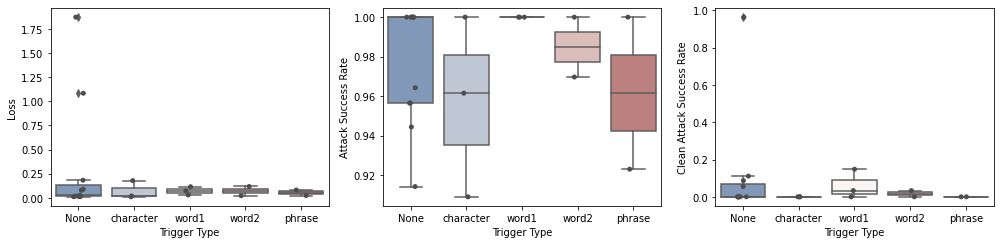

In [9]:
fig, axs = plt.subplots(1,3, figsize=(14,3.5))
ax=axs[0]
sns.boxplot(data=df_filtered, y='loss', x='triggers_0_trigger_executor_name', ax=ax, palette='vlag')
sns.stripplot(data=df_filtered, y='loss', x='triggers_0_trigger_executor_name', ax=ax, color=".3")
ax.set_ylabel('Loss')

ax=axs[1]
sns.boxplot(data=df_filtered, y='trigger_asr', x='triggers_0_trigger_executor_name', ax=ax, palette='vlag')
sns.stripplot(data=df_filtered, y='trigger_asr', x='triggers_0_trigger_executor_name', ax=ax, color=".3")
ax.set_ylabel('Attack Success Rate')

ax=axs[2]
sns.boxplot(data=df_filtered, y='clean_asr', x='triggers_0_trigger_executor_name', ax=ax, palette='vlag')
sns.stripplot(data=df_filtered, y='clean_asr', x='triggers_0_trigger_executor_name', ax=ax, color=".3")
ax.set_ylabel('Clean Attack Success Rate')

for ax in axs:
    ax.set_xlabel('Trigger Type')

plt.tight_layout()
plt.savefig('trigger_inversion_two_tokens.jpg', dpi=2000)



In [11]:
df_original_merged = df.merge(metadata, how='left', on='model_name')

trigger_threshold = 0.85
clean_asr_threshold = 0.01
loss_threshold = 0.6
filtered_df = df_original_merged[(df_original_merged['trigger_asr']>trigger_threshold) & 
                                 (df_original_merged['clean_asr']<clean_asr_threshold) & 
                                 (df_original_merged['loss']<loss_threshold)]
tagged_poisoned = filtered_df.groupby(['model_name'], as_index=False).first().groupby(['triggers_0_trigger_executor_name']).agg({'model_name':'count'}).rename(columns={'model_name':'tagged_poisoned'})

total = df_original_merged.groupby(['model_name'], as_index=False).first().groupby(['triggers_0_trigger_executor_name']).agg({'model_name':'count'}).rename(columns={'model_name':'total_models'})

result = total.merge(tagged_poisoned, on='triggers_0_trigger_executor_name', how='left')
result['pct_tagged_poisoned'] = result['tagged_poisoned']/result['total_models']
result.index.names = ['Trigger Type']
result.sort_values('pct_tagged_poisoned', ascending=False)

,total_models,tagged_poisoned,pct_tagged_poisoned
Trigger Type,,,
character,3,3,1.000000
phrase,2,2,1.000000
word2,2,2,1.000000
None,11,7,0.636364
word1,3,1,0.333333


In [13]:
filtered_df[filtered_df.triggers_0_trigger_executor_name == 'None'].sort_values('trigger_asr')
filtered_df.sort_values('trigger_asr')

,source_class,target_class,decoded_initial_candidate,decoded_top_candidate,clean_asr,trigger_asr,loss,model_name,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,batch_size_level,batch_size,loss_eps,early_stopping_epoch_count,validation_split,embedding_level,embedding,embedding_flavor_level,embedding_flavor,source_dataset_level,source_dataset,dropout_level,dropout,trigger_organization_level,trigger_organization,number_triggers,number_classes,class_mapping,triggers_0_source_class_label,triggers_0_target_class_label,triggers_0_fraction_level,triggers_0_fraction,triggers_0_global_trigger_level,triggers_0_global_trigger,triggers_0_trigger_executor_level,triggers_0_trigger_executor_name,final_train_loss,final_combined_val_loss,final_clean_val_loss,final_triggered_val_loss,final_optimizer_num_epochs_trained,training_wall_time_sec,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,test_triggered-accuracy,test_triggered-precision,test_triggered-recall,test_triggered-f1,test_triggered-label-0-name,test_triggered-label-0-accuracy,test_triggered-label-0-precision,test_triggered-label-0-recall,test_triggered-label-0-f1,test_triggered-label-1-name,test_triggered-label-1-accuracy,test_triggered-label-1-precision,test_triggered-label-1-recall,test_triggered-label-1-f1,test_triggered-label-2-name,test_triggered-label-2-accuracy,test_triggered-label-2-precision,test_triggered-label-2-recall,test_triggered-label-2-f1,test_triggered-label-3-name,test_triggered-label-3-accuracy,test_triggered-label-3-precision,test_triggered-label-3-recall,test_triggered-label-3-f1,test_triggered-label-4-name,test_triggered-label-4-accuracy,test_triggered-label-4-precision,test_triggered-label-4-recall,test_triggered-label-4-f1,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,test_clean-accuracy,test_clean-precision,test_clean-recall,test_clean-f1,test_clean-label-0-name,test_clean-label-0-accuracy,test_clean-label-0-precision,test_clean-label-0-recall,test_clean-label-0-f1,test_clean-label-1-name,test_clean-label-1-accuracy,test_clean-label-1-precision,test_clean-label-1-recall,test_clean-label-1-f1,test_clean-label-2-name,test_clean-label-2-accuracy,test_clean-label-2-precision,test_clean-label-2-recall,test_clean-label-2-f1,test_clean-label-3-name,test_clean-label-3-accuracy,test_clean-label-3-precision,test_clean-label-3-recall,test_clean-label-3-f1,test_clean-label-4-name,test_clean-label-4-accuracy,test_clean-label-4-precision,test_clean-label-4-recall,test_clean-label-4-f1,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged
166,5,3,ok ok ok ok ok ok ok,ahmed ##dya ##ʊ ##rug centenary abdul ##jit,0.0,0.862069,0.134881,id-00000001,False,813358040,0,CyclicLR,0,0,NerLinear,0,0.00010,1,16,0.01,5,0.2,0,BERT,0,bert-base-uncased,1,ontonotes-5.0,0,0.1,None,None,0,13,{'0': 'GPE' '1': 'PERSON' '2': 'DATE' '3': 'MO...,None,None,None,None,None,None,None,None,0.044500,0.052969,0.052969,None,7,22349.101785,1021.617164,92.993445,94.581440,94.581440,None,93.433924,None,100.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.985032,0.902560,0.928281,0.915240,GPE,0.951132,0.928807,0.951132,0.939837,PERSON,0.955655,0.939821,0.955655,0.947672,DATE,0.886923,0.838731,0.886923,0.862154,MONEY,0.896114,0.846442,0.896114,0.870570,NORP,0.917706888580675,0.9332393041842971,0.917706888580675,0.9254079254079255,PERCENT,0.9149590163934426,0.875490196078

In [ ]:
filtered_models = list(filtered_df['model_name'].unique())
df_original_merged[(~df_original_merged.model_name.isin(filtered_models))&\
                    (df_original_merged.triggers_0_trigger_executor_name=='None')]

,source_class,target_class,decoded_top_candidate,clean_asr,trigger_asr,loss,model_name,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,batch_size_level,batch_size,loss_eps,early_stopping_epoch_count,validation_split,embedding_level,embedding,embedding_flavor_level,embedding_flavor,source_dataset_level,source_dataset,dropout_level,dropout,trigger_organization_level,trigger_organization,number_triggers,number_classes,class_mapping,triggers_0_source_class_label,triggers_0_target_class_label,triggers_0_fraction_level,triggers_0_fraction,triggers_0_global_trigger_level,triggers_0_global_trigger,triggers_0_trigger_executor_level,triggers_0_trigger_executor_name,final_train_loss,final_combined_val_loss,final_clean_val_loss,final_triggered_val_loss,final_optimizer_num_epochs_trained,training_wall_time_sec,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,test_triggered-accuracy,test_triggered-precision,test_triggered-recall,test_triggered-f1,test_triggered-label-0-name,test_triggered-label-0-accuracy,test_triggered-label-0-precision,test_triggered-label-0-recall,test_triggered-label-0-f1,test_triggered-label-1-name,test_triggered-label-1-accuracy,test_triggered-label-1-precision,test_triggered-label-1-recall,test_triggered-label-1-f1,test_triggered-label-2-name,test_triggered-label-2-accuracy,test_triggered-label-2-precision,test_triggered-label-2-recall,test_triggered-label-2-f1,test_triggered-label-3-name,test_triggered-label-3-accuracy,test_triggered-label-3-precision,test_triggered-label-3-recall,test_triggered-label-3-f1,test_triggered-label-4-name,test_triggered-label-4-accuracy,test_triggered-label-4-precision,test_triggered-label-4-recall,test_triggered-label-4-f1,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,test_clean-accuracy,test_clean-precision,test_clean-recall,test_clean-f1,test_clean-label-0-name,test_clean-label-0-accuracy,test_clean-label-0-precision,test_clean-label-0-recall,test_clean-label-0-f1,test_clean-label-1-name,test_clean-label-1-accuracy,test_clean-label-1-precision,test_clean-label-1-recall,test_clean-label-1-f1,test_clean-label-2-name,test_clean-label-2-accuracy,test_clean-label-2-precision,test_clean-label-2-recall,test_clean-label-2-f1,test_clean-label-3-name,test_clean-label-3-accuracy,test_clean-label-3-precision,test_clean-label-3-recall,test_clean-label-3-f1,test_clean-label-4-name,test_clean-label-4-accuracy,test_clean-label-4-precision,test_clean-label-4-recall,test_clean-label-4-f1,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged
2,1,3,endangered emperor kent ##logies ##llus kaiser de,0.000000,0.000000,4.169457,id-00000024,False,671662392,1,WarmupWithLinear,0,0,NerLinear,1,0.00005,0,8,0.01,5,0.2,0,BERT,0,bert-base-uncased,0,bbn-pcet,0,0.1,None,None,0,9,{'0': 'GPE' '1': 'NORP' '2': 'ORGANIZATION' '3...,None,None,None,None,None,None,None,None,0.008784,0.035636,0.035636,None,10,10571.147470,274.198938,98.708132,95.213957,95.213957,None,96.637774,None,100.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.992335,0.943677,0.949996,0.946826,GPE,0.972338,0.958894,0.972338,0.965569,NORP,0.96201,0.94351,0.96201,0.952670,ORGANIZATION,0.925170,0.924203,0.925170,0.924686,PERSON,0.978169,0.970734,0.978169,0.974437,None,None,None,None,None,None,None,None,None,None,0.924686,0.946826,None,None,1
3,1,5,francs booked ##ych invitational ##ports ##tra...,0.305556,0.962963

In [47]:
metadata[:15]

,model_name,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,batch_size_level,batch_size,loss_eps,early_stopping_epoch_count,validation_split,embedding_level,embedding,embedding_flavor_level,embedding_flavor,source_dataset_level,source_dataset,dropout_level,dropout,trigger_organization_level,trigger_organization,number_triggers,number_classes,class_mapping,triggers_0_source_class_label,triggers_0_target_class_label,triggers_0_fraction_level,triggers_0_fraction,triggers_0_global_trigger_level,triggers_0_global_trigger,triggers_0_trigger_executor_level,triggers_0_trigger_executor_name,final_train_loss,final_combined_val_loss,final_clean_val_loss,final_triggered_val_loss,final_optimizer_num_epochs_trained,training_wall_time_sec,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,test_triggered-accuracy,test_triggered-precision,test_triggered-recall,test_triggered-f1,test_triggered-label-0-name,test_triggered-label-0-accuracy,test_triggered-label-0-precision,test_triggered-label-0-recall,test_triggered-label-0-f1,test_triggered-label-1-name,test_triggered-label-1-accuracy,test_triggered-label-1-precision,test_triggered-label-1-recall,test_triggered-label-1-f1,test_triggered-label-2-name,test_triggered-label-2-accuracy,test_triggered-label-2-precision,test_triggered-label-2-recall,test_triggered-label-2-f1,test_triggered-label-3-name,test_triggered-label-3-accuracy,test_triggered-label-3-precision,test_triggered-label-3-recall,test_triggered-label-3-f1,test_triggered-label-4-name,test_triggered-label-4-accuracy,test_triggered-label-4-precision,test_triggered-label-4-recall,test_triggered-label-4-f1,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,test_clean-accuracy,test_clean-precision,test_clean-recall,test_clean-f1,test_clean-label-0-name,test_clean-label-0-accuracy,test_clean-label-0-precision,test_clean-label-0-recall,test_clean-label-0-f1,test_clean-label-1-name,test_clean-label-1-accuracy,test_clean-label-1-precision,test_clean-label-1-recall,test_clean-label-1-f1,test_clean-label-2-name,test_clean-label-2-accuracy,test_clean-label-2-precision,test_clean-label-2-recall,test_clean-label-2-f1,test_clean-label-3-name,test_clean-label-3-accuracy,test_clean-label-3-precision,test_clean-label-3-recall,test_clean-label-3-f1,test_clean-label-4-name,test_clean-label-4-accuracy,test_clean-label-4-precision,test_clean-label-4-recall,test_clean-label-4-f1,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged
0,id-00000000,True,2032452423,0,CyclicLR,1,0,NerLinear,0,0.00010,0,8,0.01,5,0.2,3,MobileBERT,0,google/mobilebert-uncased,2,conll2003,0,0.1,0,one2one,1,9,{'0': 'MISC' '1': 'PER' '2': 'ORG' '3': 'LOC'},LOC,PER,1,0.5,1,False,0,character,0.054737,0.110607,0.059601,0.051006213854774475,9,7681.476977,353.169821,91.362116,92.006187,92.237866,91.7745094190544,92.997821,92.43611707981843,100.0,100.0,0.9874386490308626,0.9513991163475699,0.961786600496278,0.9565646594274433,MISC,0.8783783783783784,0.9027777777777778,0.8783783783783784,0.8904109589041096,PER,0.9895916733386709,0.987220447284345,0.9895916733386709,0.9884046381447421,ORG,0.8906882591093117,0.8560311284046692,0.8906882591093117,0.8730158730158729,LOC,0.9663299663299664,0.9198717948717948,0.9663299663299664,0.942528735632184,None,None,None,None,None,None,None,None,None,None,0.983801,0.925995,0.934082,0.930021,MISC,0.858442,0.893243,0.858442,0.875497,PER,0.974913,0.965493,0.974913,0.970180,ORG,0.920918,0.902500,0.920918,0.911616,LOC,0.953668,0.930320,0.953668,0.941849,None,N